<a href="https://colab.research.google.com/github/brendontj/CC-Fraud-Detection/blob/master/cc_fraud_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [38]:
data = pd.read_csv('creditcard.csv')
print('Quantidade de linhas do dataset {}'.format(data.shape[0]))
data.head()

Quantidade de linhas do dataset 284807


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [39]:
df = data.dropna()
df = df.drop(columns="Time") # Removing column time, because is not relevant
df['ID']= np.arange(1,len(df.Class)+1)
print('Quantidade de linhas do dataset sem valor Null/NaN/NaT {}'.format(df.shape[0]))
df.head()

Quantidade de linhas do dataset sem valor Null/NaN/NaT 284807


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,ID
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,1
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,2
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,3
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,4
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,5


In [40]:
x_train,  x_test, y_train, y_test = train_test_split(df.drop(['ID', 'Class'], axis=1), df['Class'], test_size=0.35, random_state = 0)
print('Dados de treino {}\n'.format(x_train.shape))
print('Dados de teste  {}\n'.format(x_test.shape))

Dados de treino (185124, 29)

Dados de teste  (99683, 29)



In [41]:
mic = mutual_info_classif(x_train, y_train)
mic

array([0.002369  , 0.0032356 , 0.00501216, 0.00510026, 0.0026446 ,
       0.00235971, 0.00385865, 0.00202635, 0.00428377, 0.00749769,
       0.00712542, 0.00767551, 0.00052814, 0.00829204, 0.00035423,
       0.00623598, 0.00843003, 0.00426973, 0.00149931, 0.0013635 ,
       0.00262939, 0.00049279, 0.0009862 , 0.00077227, 0.00064316,
       0.00059846, 0.00239366, 0.00190169, 0.00148315])

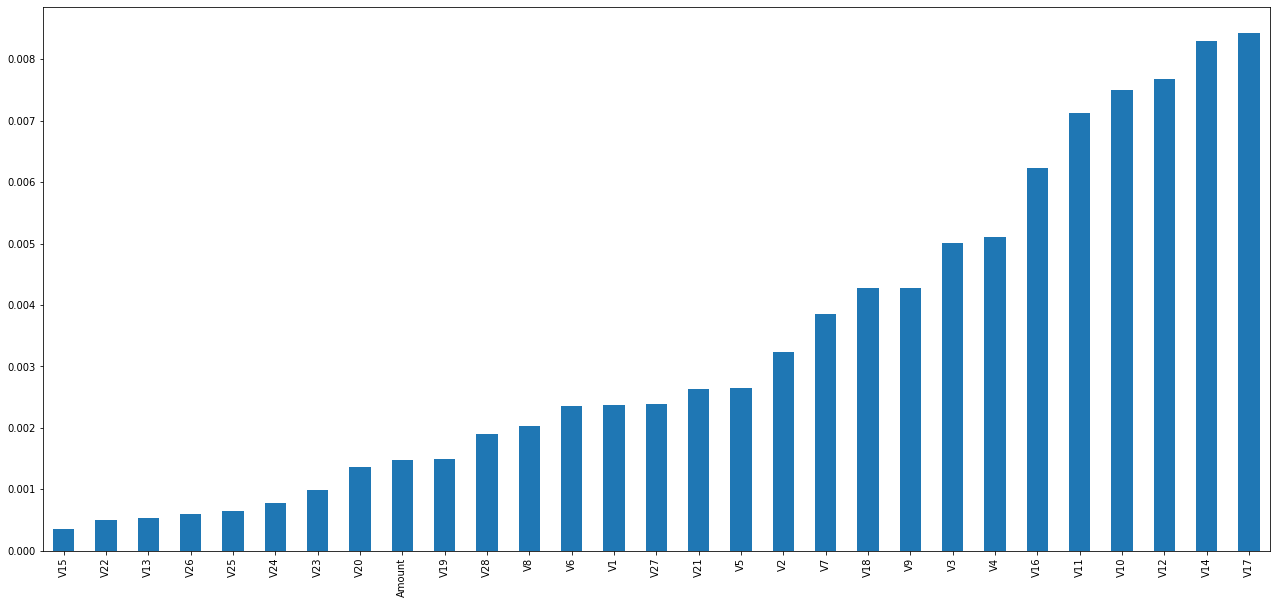

In [42]:
mic = pd.Series(mic)
mic.index = x_train.columns
mic = mic.sort_values(ascending = True)
mic.plot.bar(figsize=(22,10))

In [46]:
selection = SelectKBest(mutual_info_classif, k= 20).fit(x_train, y_train)

In [56]:
X_train = x_train[x_train.columns[selection.get_support()]]

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
predictions = rf.predict(X_train)

print(classification_report(y_train, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    184802
           1       1.00      1.00      1.00       322

    accuracy                           1.00    185124
   macro avg       1.00      1.00      1.00    185124
weighted avg       1.00      1.00      1.00    185124



In [60]:
X_test = x_test[x_test.columns[selection.get_support()]]
predictions_test = rf.predict(X_test)
print(classification_report(y_test, predictions_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     99513
           1       0.95      0.77      0.85       170

    accuracy                           1.00     99683
   macro avg       0.97      0.89      0.93     99683
weighted avg       1.00      1.00      1.00     99683

